In [1]:
import psycopg2
import numpy as np
from psycopg2.extras import execute_values
from faiss import read_index
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

/home/dml/.pyenv/versions/so_q_recom/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar modelo e indice

In [4]:
model = SentenceTransformer("SBERT_python_10k_1e")
index = read_index("python_10k_1e.index")

# Traer nuevas preguntas

In [6]:
connection = psycopg2.connect(user="postgres", password="postgres", host="127.0.0.1", port="54320", database="stack_overflow")

In [7]:
MIN_ANSWERS = 9
with connection:
    with connection.cursor() as cursor:
        cursor.execute(f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 3000""")
        posts = cursor.fetchall()

# Encontrar las preguntas cercanas y sus vectores de distancia

In [8]:
posts_texts = []
posts_ids = []
for p_id, title, body in posts:
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_ids.append(p_id)
    posts_texts.append(post_text)

posts_vectors = model.encode(posts_texts)

In [9]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(1371, 768)

## Cantidad de vectores en relacion al radio

In [10]:
def get_found_vectors_dist(limits):
    k_vects = np.array([limits[i+1]-limits[i] for i in range(len(limits) - 1)])
    return k_vects.mean(), k_vects.std()

In [11]:
test_radius = [10, 20, 30, 40, 50]
k_vects_dist = []
for radius in test_radius:
    limits, distances, similar_questions = index.range_search(posts_vectors, radius)
    k_vects_dist.append(get_found_vectors_dist(limits))
k_vects_dist = np.array(k_vects_dist)

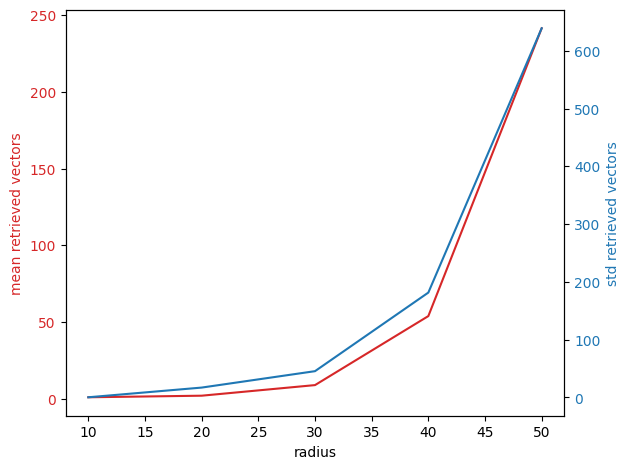

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('radius')
ax1.set_ylabel('mean retrieved vectors', color=color)
ax1.plot(test_radius, k_vects_dist[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('std retrieved vectors', color=color) 
ax2.plot(test_radius, k_vects_dist[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


## Distancia de los vectores en funcion de K

In [51]:
def get_question_vectors(questions, base_vectors):
    questions_ids = tuple(set([int(q) for qg in questions for q in qg if int(q) not in base_vectors]))
    if len(questions_ids) == 0:
        return base_vectors
    with connection:
        with connection.cursor() as cursor:
            cursor.execute(f"""select p.id, p.title, p.body_text
            from posts_19 p
            where p.id IN %s""", (questions_ids,))
            questions_data = cursor.fetchall()
            
    questions_texts = []
    questions_ids = []
    for p_id, title, body in questions_data:
        post_text = body
        if title is not None:
            post_text = title + "\n\n" + body
        questions_ids.append(p_id)
        questions_texts.append(post_text)
    
    questions_vectors = model.encode(questions_texts)
    for q_id, q_v in zip(questions_ids, questions_vectors):
        base_vectors[q_id] = q_v
    return base_vectors

In [52]:
def get_vector_distance_dist(posts_vectors, similar_questions, q_vectors):
    exact_distances = []
    for p_vector, similar_qs in zip(posts_vectors, similar_questions):
        for s_q in similar_qs:
            sq_vector = q_vectors[s_q]
            exact_distances.append(np.linalg.norm(p_vector-sq_vector))
    exact_distances = np.array(exact_distances)
    return exact_distances.mean(), exact_distances.std()

In [53]:
test_k = [50, 100, 500, 1000, 5000, 10000, 30000, 50000]
test_k = [50, 100]
distance_dist = []
q_vectors = dict()
for k in test_k:
    distances, similar_questions = index.search(posts_vectors, k)
    q_vectors = get_question_vectors(similar_questions, q_vectors)
    distance_dist.append(get_vector_distance_dist(posts_vectors, similar_questions, q_vectors))
distance_dist = np.array(distance_dist)

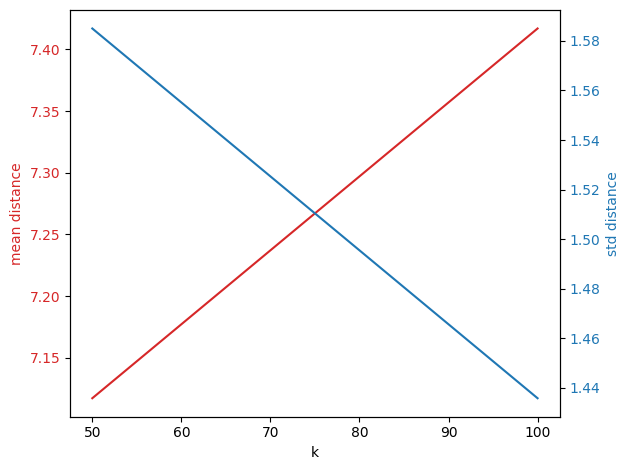

In [54]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('mean distance', color=color)
ax1.plot(test_k, distance_dist[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('std distance', color=color) 
ax2.plot(test_k, distance_dist[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [55]:
distance_dist

array([[7.117303 , 1.5849855],
       [7.4168863, 1.4358379]], dtype=float32)

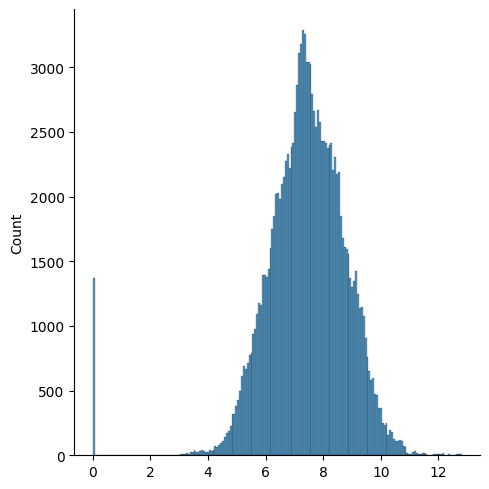

In [57]:
exact_distances = []
for p_vector, similar_qs in zip(posts_vectors, similar_questions):
    for idx, s_q in enumerate(similar_qs):
        sq_vector = q_vectors[s_q]
        exact_distances.append(np.linalg.norm(p_vector-sq_vector))
sns.displot(exact_distances)

In [ ]:
with connection.cursor() as cursor:
            execute_values(cursor, """select q_id, sq_id, q_a.owner_user_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, sq_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    JOIN posts_19 sq ON sq.id = sq_id
                                    JOIN posts_19 sq_a ON sq_a.id = sq.accepted_answer_id
                                    WHERE sq_a.owner_user_id=q_a.owner_user_id""",
                                    wkkdnin[["q_id", "sq_id"]].values.tolist(), page_size=len(
                                            

                                            wñ"jejk"and
                                    ))
            q_ds = cursor.fetchall()
            q_ds = pd.DataFrame(q_ds, columns=["q_id", "sq_id", "user_id", "score"])

### Recall vs k

In [59]:
def get_recall_dist(features_df):
    with connection:
        with connection.cursor() as cursor:
            execute_values(cursor, """select q_id, sq_id, q_a.owner_user_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, sq_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    JOIN posts_19 sq ON sq.id = sq_id
                                    JOIN posts_19 sq_a ON sq_a.id = sq.accepted_answer_id
                                    WHERE sq_a.owner_user_id=q_a.owner_user_id""",
                                    features_df[["q_id", "sq_id"]].values.tolist(), page_size=len(features_df))
            q_ds = cursor.fetchall()
            q_ds = pd.DataFrame(q_ds, columns=["q_id", "sq_id", "user_id", "score"])

        with connection.cursor() as cursor:
            cursor.execute("""select a.parent_id, count(*)
                                FROM posts_19 a
                                WHERE a.parent_id in %s
                                GROUP BY a.parent_id""",
                                (tuple(q_ds["q_id"].unique().tolist()),))
            ans_ds = cursor.fetchall()
            ans_ds = pd.DataFrame(ans_ds, columns=["q_id", "answers"])
    recall_df = q_ds.drop_duplicates(["q_id", "user_id"]).groupby("q_id").count().merge(ans_ds, on="q_id")
    recall_df["recall"] = recall_df["sq_id"] / recall_df["answers"]
    return recall_df["recall"].mean(), recall_df["recall"].std()

In [70]:
test_k = [50, 100, 500, 1000, 5000, 10000, 30000, 50000]
recall_dist = []
for k in test_k:
    distances, similar_questions = index.search(posts_vectors[:50], k)
    features_df = pd.DataFrame(list(zip(posts_ids, similar_questions)), columns=["q_id", "sq_id"]).explode("sq_id")
    features_df["sq_id"] = features_df["sq_id"].astype(int)
    recall_dist.append(get_recall_dist(features_df))
recall_dist = np.array(recall_dist)

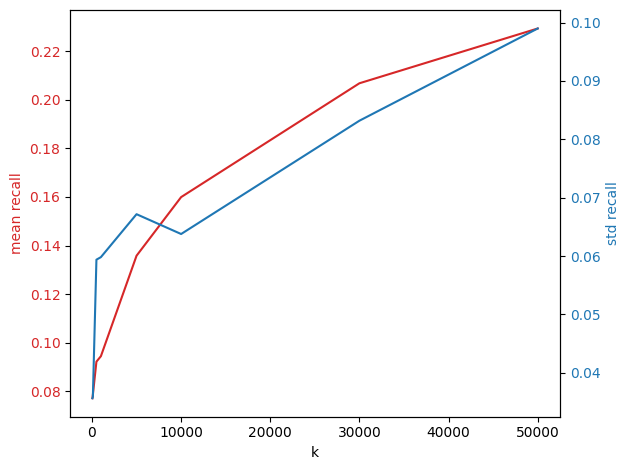

In [71]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('mean recall', color=color)
ax1.plot(test_k, recall_dist[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('std recall', color=color) 
ax2.plot(test_k, recall_dist[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()